In [1]:
import fiona
import pandas as pd
import shapefile as sf
from arcgis.gis import GIS
from statistics import mean
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.geometry import LineString

In [2]:
# Input and output file paths
file1 = 'inps/drainage_1_level.shp'
file2 = 'inps/drainage_2_level.shp'
hous0 = 'inps/household_0_level.shp'
hous1 = 'inps/household_1_level.shp'
hous2 = 'inps/household_2_level.shp'

In [3]:
# Extract shapefile
spf_d1 = sf.Reader(file1)
spf_d2 = sf.Reader(file2)
spf_h0 = sf.Reader(hous0)

In [4]:
# Extract record class from shapefile
rec_d1 = spf_d1.records()
rec_d2 = spf_d2.records()
rec_h0 = spf_h0.records()

In [5]:
# Extract shaperecord class from shapefile
src_d1 = spf_d1.shapeRecords()
src_d2 = spf_d2.shapeRecords()
src_h0 = spf_h0.shapeRecords()

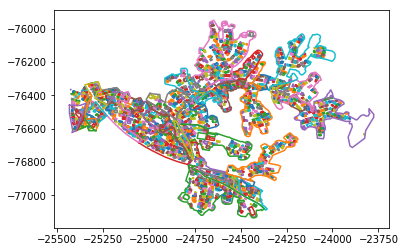

There are 2084 houses in 45 drinage areas!


In [6]:
for sh in spf_h0.shapeRecords():
    x = [i[0] for i in sh.shape.points[:]]
    y = [i[1] for i in sh.shape.points[:]]
    plt.plot(x,y)
for da in spf_d1.shapeRecords():
    x = [i[0] for i in da.shape.points[:]]
    y = [i[1] for i in da.shape.points[:]]
    plt.plot(x,y)
plt.show()
print('There are ' + str(len(rec_h0)) + ' houses in ' + str(len(rec_d1)) + ' drinage areas!')

In [7]:
def findPolygonCentroid(shaperecords):
    src = shaperecords
    x = [LineString(src[i].shape.points[:]).centroid.x for i in range(len(src))]
    y = [LineString(src[i].shape.points[:]).centroid.y for i in range(len(src))]
    return [x, y]

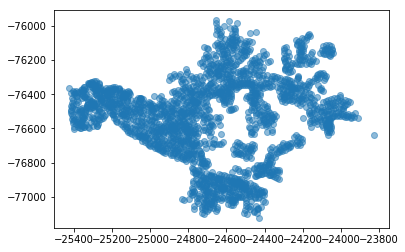

In [8]:
centriod = findPolygonCentroid(src_h0)
plt.scatter(centriod[0], centriod[1], alpha=0.5)
plt.show()

In [9]:
def isRayIntersectsSegment(poi,s_poi,e_poi): #[x,y] [lng,lat]
    # https://www.jianshu.com/p/ba03c600a557
    # 输入：判断点，边起点，边终点，都是[lng,lat]格式数组
    if s_poi[1]==e_poi[1]: #排除与射线平行、重合，线段首尾端点重合的情况
        return False
    if s_poi[1]>poi[1] and e_poi[1]>poi[1]: #线段在射线上边
        return False
    if s_poi[1]<poi[1] and e_poi[1]<poi[1]: #线段在射线下边
        return False
    if s_poi[1]==poi[1] and e_poi[1]>poi[1]: #交点为下端点，对应spoint
        return False
    if e_poi[1]==poi[1] and s_poi[1]>poi[1]: #交点为下端点，对应epoint
        return False
    if s_poi[0]<poi[0] and e_poi[1]<poi[1]: #线段在射线左边
        return False
    xseg=e_poi[0]-(e_poi[0]-s_poi[0])*(e_poi[1]-poi[1])/(e_poi[1]-s_poi[1]) #求交
    if xseg<poi[0]: #交点在射线起点的左侧
        return False
    return True  #排除上述情况之后
def isPoiWithinPoly(poi,poly):
    # https://www.jianshu.com/p/ba03c600a557
    #输入：点，多边形三维数组
    #poly=[[[x1,y1],[x2,y2],……,[xn,yn],[x1,y1]],[[w1,t1],……[wk,tk]]] 三维数组

    #可以先判断点是否在外包矩形内 
    #if not isPoiWithinBox(poi,mbr=[[0,0],[180,90]]): return False
    #但算最小外包矩形本身需要循环边，会造成开销，本处略去
    sinsc = 0 #交点个数
    epoly = poly
    #for epoly in poly: #循环每条边的曲线->each polygon 是二维数组[[x1,y1],…[xn,yn]]
    for i in range(len(epoly)-1): #[0,len-1]
        s_poi = epoly[i]
        e_poi = epoly[i+1]
        if isRayIntersectsSegment(poi,s_poi,e_poi):
             sinsc += 1 #有交点就加1
    return True if sinsc%2 == 1 else  False

In [10]:
def genNewId(records1, records2):
    # 取排水区域图层与房屋图层的交集，即，将每个房屋添加排水区域的编号
    # 输入：排水区域地图图层，房屋区域地图图层
    # 输出：列表文件
    solu = []
    da_rec = records1           # 地图文件的record
    hs_rec = records2           # 房屋文件的record
    for num_h in range(len(hs_rec)):
        shp = spf_h0.shape(num_h)       # 房屋文件中的每个房屋shape
        poi = (mean([tp[0] for tp in shp.points]), mean([tp[1] for tp in shp.points]))
        for num_d in range(len(da_rec)):
            shp_d = spf_d1.shape(num_d) # 地图文件中的每个区域shape
            poly = shp_d.points         # 每个区域的顶点集合
            temp = hs_rec[num_h]
            if isPoiWithinPoly(poi, poly):
                if len(temp) == 2:
                    temp.append(num_d + 1)
        solu.append(temp)
    for ele in solu:
        if len(ele) == 2:
            ele.append(9999)            # '9999'为'null'
    return solu

In [11]:
newRec = genNewId(rec_d1, rec_h0)

In [53]:
rec_d1

[[15],
 [17],
 [26],
 [28],
 [30],
 [44],
 [45],
 [54],
 [55],
 [58],
 [59],
 [69],
 [87],
 [84],
 [88],
 [92],
 [99],
 [147],
 [151],
 [146],
 [145],
 [125],
 [124],
 [122],
 [120],
 [118],
 [113],
 [112],
 [144],
 [175],
 [193],
 [195],
 [200],
 [202],
 [206],
 [208],
 [209],
 [218],
 [221],
 [223],
 [228],
 [172],
 [153],
 [167],
 [167]]

In [51]:
def houseInfoCal(newRec, rec_d1):
    print(rec_d1)

In [52]:
houseInfoCal(newRec, rec_d1)

[[15], [17], [26], [28], [30], [44], [45], [54], [55], [58], [59], [69], [87], [84], [88], [92], [99], [147], [151], [146], [145], [125], [124], [122], [120], [118], [113], [112], [144], [175], [193], [195], [200], [202], [206], [208], [209], [218], [221], [223], [228], [172], [153], [167], [167]]


In [45]:
[rec_d1[i][0] for i in range(len(rec_d1))]

[15,
 17,
 26,
 28,
 30,
 44,
 45,
 54,
 55,
 58,
 59,
 69,
 87,
 84,
 88,
 92,
 99,
 147,
 151,
 146,
 145,
 125,
 124,
 122,
 120,
 118,
 113,
 112,
 144,
 175,
 193,
 195,
 200,
 202,
 206,
 208,
 209,
 218,
 221,
 223,
 228,
 172,
 153,
 167,
 167]

In [ ]:
r = sf.Reader(hous0)
w = sf.Writer(hous1, shapeType = r.shapeType)
w.fields = list(r.fields)
w.fields.extend([['id_1', 'N', 4, 0]])
for ele in newAttr:
    w.record(ele[0], ele[1], ele[2])

In [ ]:
ele = newRec[0]
ele

In [ ]:
spf_h0 = sf.Reader(hous0)
spf_h1 = sf.Writer(hous1)
spf_h1 = spf_h0
spf_h1.fields = spf_h0.fields
spf_h1.fields.append(['id_1', 'N', 4, 0])
for ele in newAttr:
    assert spf_h1.records() == [ele[0],ele[1],ele[2]]
spf_h1.close()

In [ ]:
spf_h0.shapeType

In [ ]:
spf_h0.shapeType == sf.POLYGON

In [ ]:
spf_h0.shapeTypeName == 'POLYGON'

In [ ]:
len(spf_h0)

In [ ]:
spf_h0.bbox

In [ ]:
shapes = spf_h0.shapes()
len(shapes)

In [ ]:
fields = spf_h0.fields
fields

In [ ]:
shapeRecs = spf_h0.shapeRecords()
len(shapeRecs)

In [ ]:
shapeRecs[3].record[:]

In [ ]:
shapeRecs[3].shape.points[:]

In [ ]:
polygon = Polygon(shapeRecs[3].shape.points[:])
polygon.area

In [ ]:
LineString(shapeRecs[3].shape.points[:]).centroid.x

In [ ]:
with shapefile.Writer(hous1) as shp:
	pass

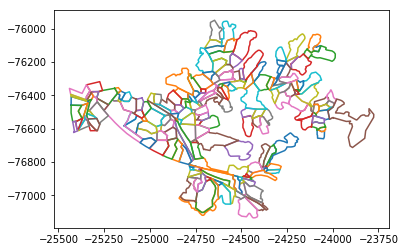

There are 45 elements!
attribute: [[15], [17], [26], [28], [30], [44], [45], [54], [55], [58], [59], [69], [87], [84], [88], [92], [99], [147], [151], [146], [145], [125], [124], [122], [120], [118], [113], [112], [144], [175], [193], [195], [200], [202], [206], [208], [209], [218], [221], [223], [228], [172], [153], [167], [168]]


In [46]:
spf_d1 = sf.Reader(file1)
for sh in spf_d2.shapeRecords():
    x = [i[0] for i in sh.shape.points[:]]
    y = [i[1] for i in sh.shape.points[:]]
    plt.plot(x,y)
plt.show()
nb = spf_d1.records()
print('There are ' + str(len(nb)) + ' elements!')
print('attribute:', nb)

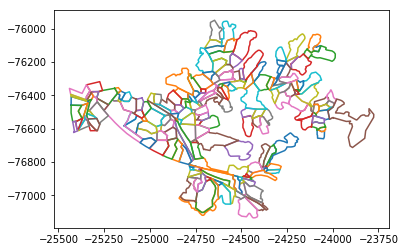

There are 219 elements!
attribute: [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [12], [13], [14], [15], [901], [11], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [32], [33], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [49], [48], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [62], [63], [64], [65], [66], [67], [68], [61], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [86], [87], [88], [89], [90], [91], [92], [907], [155], [154], [902], [93], [94], [95], [96], [97], [98], [99], [100], [101], [103], [102], [104], [105], [106], [107], [108], [109], [110], [111], [112], [903], [113], [114], [115], [116], [117], [118], [120], [122], [123], [124], [125], [126], [127], [128], [130], [131], [132], [134], [135], [136], [138], [139], [140], [141], [142], [143], [144], [145], [146], [147], [148], [149], [150], [151], [152], [153], [156], [157], [158

In [13]:
spf_d2 = sf.Reader(file2)
for sh in spf_d2.shapeRecords():
    x = [i[0] for i in sh.shape.points[:]]
    y = [i[1] for i in sh.shape.points[:]]
    plt.plot(x,y)
plt.show()
nb = spf_d2.records()
print('There are ' + str(len(nb)) + ' elements!')
print('attribute:', nb)

In [15]:
nb

[[1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9],
 [10],
 [12],
 [13],
 [14],
 [15],
 [901],
 [11],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25],
 [26],
 [27],
 [28],
 [29],
 [30],
 [32],
 [33],
 [35],
 [36],
 [37],
 [38],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [49],
 [48],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55],
 [56],
 [57],
 [58],
 [59],
 [60],
 [62],
 [63],
 [64],
 [65],
 [66],
 [67],
 [68],
 [61],
 [69],
 [70],
 [71],
 [72],
 [73],
 [74],
 [75],
 [76],
 [77],
 [78],
 [79],
 [80],
 [81],
 [82],
 [83],
 [84],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92],
 [907],
 [155],
 [154],
 [902],
 [93],
 [94],
 [95],
 [96],
 [97],
 [98],
 [99],
 [100],
 [101],
 [103],
 [102],
 [104],
 [105],
 [106],
 [107],
 [108],
 [109],
 [110],
 [111],
 [112],
 [903],
 [113],
 [114],
 [115],
 [116],
 [117],
 [118],
 [120],
 [122],
 [123],
 [124],
 [125],
 [126],
 [127],
 [128],
 [130],
 [131],
 [132],
 [134],
 [135],
 [136],
 [138],
 [139],
 [140],
 [141],


In [ ]:
inps = '.\inps\drainage_1_inps.csv'

In [ ]:
def read_inps(inps):
    df = pd.read_csv(inps)
    return df

In [ ]:
def fill_river_persentage(rain_drainage,max_drainage):
    fill_persentage = rain_drainage / max_drainage
    return fill_persentage

In [ ]:
df = read_inps(inps)
df.head()

In [ ]:
rain_drainage = df['Amount']
max_drainage = df['Capacity']

In [ ]:
persentage = fill_river_persentage(rain_drainage,max_drainage)

In [ ]:
spf_d1 = sf.Reader(file1)
spf_h1 = sf.Reader(hous1)
da_rec = spf_d1.records()
hs_rec = spf_h1.records()
for sh in spf_h0.shapeRecords():
    x = [i[0] for i in sh.shape.points[:]]
    y = [i[1] for i in sh.shape.points[:]]
    plt.plot(x,y)
for da in spf_d1.shapeRecords():
    x = [i[0] for i in da.shape.points[:]]
    y = [i[1] for i in da.shape.points[:]]
    plt.plot(x,y)
plt.show()
print('There are ' + str(len(hs_rec)) + ' houses in ' + str(len(da_rec)) + ' drinage areas!')